<a href="https://colab.research.google.com/github/SaadTazroute/JurisprudencesClassification/blob/master/03_CamemBERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO


from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
np.set_printoptions(precision=3)
# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

In [ ]:
import re
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

 Prepare data

In [ ]:
import numpy as np
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


 Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

path='/content/drive/My Drive/Freemium02.csv'
import pandas as pd
data_df = pd.read_csv(path, error_bad_lines=False)

data_df=data_df.dropna(how = 'any')
data_df = data_df.reindex(np.random.permutation(data_df.index))
data_df.reset_index(inplace=True, drop=True)

data_df=data_df[:]
data_df.reset_index(inplace=True, drop=True)

data_df = pd.DataFrame({'content':data_df['content'],'solution':data_df['solution']})
data_df

data_df.head(2)


content solution
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 SUR LE MOYEN UNIQUE , PRIS DE LA VIOLATION DE L ' ARTICLE 9 DE LA LOI DU 16 AVRIL 1946 : ATTENDU QUE LE SYNDICAT CGT DES TRAVAILLEURS DE LA SOCIETE DU MATERIEL TECHNIQUE ET INDUSTRIEL ( MTI ) FAIT GRIEF A LA DECISION ATTAQUEE D ' AVOIR REFUSE D ' ANNULER L ' ELECTION DES DELEGUES DU PERSONNEL DE LADITE ENTREPRISE A LAQUELLE IL A ETE PROCEDE LE 9 JUIN 1969 , ALORS QUE LE SYNDICAT AUTONOME DU PERSONNEL DE LA MTI , QUI AVAIT PRESENTE DES CANDIDATS AU PREMIER TOUR , NE POUVAIT ETRE CONSIDERE COMME REPRESENTATIF AU TITRE DE LA LOI DU 27 DECEMBRE 1968 ET DE L ' ARTICLE 31 F DU LIVRE 1ER DU CODE DU TRAVAIL ; MAIS ATTENDU QU ' APRES AVOIR EXACTEMENT RAPPELE QUE LA LOI DU 16 AVRIL 1946 NE DEFINIT PAS LES ELEMENTS DU CARACTERE REPRESENTATIF QUE DOIT POSSEDER UNE ORGANISATION SYNDICALE POUR ETRE AUTORISEE A PRESENTER DES CANDIDATS AU PREMIER TOUR DES ELECTIONS DES DELEGUES DU

In [ ]:
data_df['content']=data_df['content'].astype(str)

In [ ]:
data_df = pd.DataFrame({'content':data_df['content'],'solution':data_df['solution']})
data_df['solution']=data_df['solution'].str.lower()


In [ ]:
resultat = data_df.groupby('solution')['content'].nunique()
resultat

solution
annulation                                      193
cassation                                     54665
irrecevabilite                                 2534
nonlieu statuer                                 139
qpc nonlieu renvoi conseil constitutionnel      278
rejet                                         69709
Name: content, dtype: int64

In [ ]:
#supprimer les catégories de nombre inférieur au seuil
seuil=20
data_df = data_df[data_df.groupby('solution').solution.transform('count')>seuil].copy() 
data_df
resultat = data_df.groupby('solution')['content'].nunique()
resultat


solution
annulation                                      193
cassation                                     54665
irrecevabilite                                 2534
nonlieu statuer                                 139
qpc nonlieu renvoi conseil constitutionnel      278
rejet                                         69709
Name: content, dtype: int64

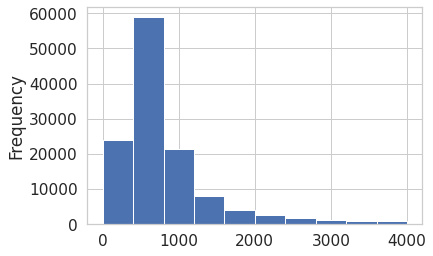

In [ ]:

data_df.content.apply(lambda x: len(x.split())).plot(kind='hist',range=(0,4000))

In [ ]:
data_df['len_txt'] =data_df.content.apply(lambda x: len(x.split()))
data_df

content  ... len_txt
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
data_df.describe()

,len_txt
count,127587.000000
mean,989.955489
std,1504.192012
min,11.000000
25%,441.000000
50%,630.000000
75%,986.000000
max,104835.000000


In [ ]:
train_raw = data_df[['content', 'solution']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

content   solution
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
for l in np.unique(train_raw['solution']):
  print(l)

annulation
cassation
irrecevabilite
nonlieu statuer
qpc nonlieu renvoi conseil constitutionnel
rejet


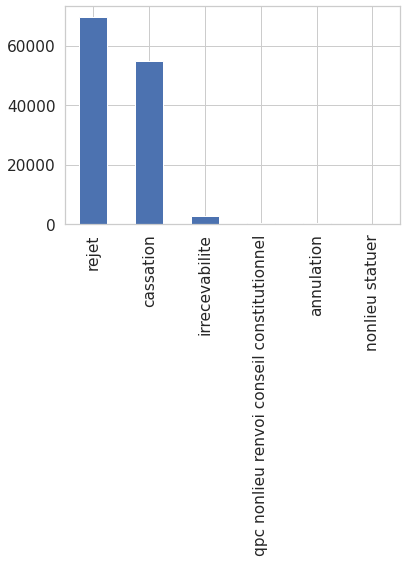

In [ ]:
train_raw['solution'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [ ]:
train_raw=train_raw.rename(columns = {'content':'text', 'solution':'label'})
train_raw.head()

text      label
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

text  label
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
num_labels=len(np.unique(train_raw['label']))


In [ ]:
train = train_raw.copy()

In [ ]:
train = train.reindex(np.random.permutation(train.index))
train['len_txt'] =train.text.apply(lambda x: len(x.split()))
train = train[train.len_txt >249]
train.head()

text  ...  len_txt
109282                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

text  ...  len_txt
124171                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      SUR LE YEN UNIQUE : VU L ' ARTICLE 6 DE L ' ORDONNANCE DU 23 OCTOBRE 1958 , ENSELE LES ARTICLES 20 DU DECRET DU 6 JUIN 1959 ET 15 DU DECRET DU 20 NOVERE 1959 ; ATTENDU QU ' AVANT DE RENDRE UNE ORDONNANCE PRONONCANT UNE EXPROPRIATION POUR CAUSE D ' UTILITE PUBLIQUE , LE GISTRAT EST TENU DE VERIFIER SI TOUTES LES FORLITES PRESCRITES PAR LA LOI ONT ETE ACCOLIES ; QU ' IL DOIT CONSTATER CETTE VERIFICATION EN VISANT DANS L ' ORDONNANCE LES PIECES PRODUITES A L ' APPUI DE LA DENDE ; ATTENDU QUE L ' ORDONNANCE ATTAQUEE , EN DATE DU 9 NOVERE 1970 , QUI PRONONCE L ' EXPROPRIATION POUR CAUSE D ' UTILITE PUBLIQUE , AU PROFIT DE LA COUNE DE GUISE , D ' UN TERRAIN SIS SUR LE TERRITOIRE DE CETTE COUNE ET APPARTENANT A JEAN X ..., NE FAIT NTION NI DE LA TRANSSSION DU DOSSIER DE L ' ENQUETE

In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

text  ...  len_txt
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              SUR LE YEN UNIQUE : VU L ' ARTICLE 6 DE L ' ORDONNANCE DU 23 OCTOBRE 1958 , ENSELE LES ARTICLES 20 DU DECRET DU 6 JUIN 1959 ET 15 DU DECRET DU 20 NOVERE 1959 ; ATTENDU QU ' AVANT DE RENDRE UNE ORDONNANCE PRONONCANT UNE EXPROPRIATION POUR CAUSE D ' UTILITE PUBLIQUE , LE GISTRAT EST TENU DE VERIFIER SI TOUTES LES FORLITES PRESCRITES PAR LA LOI ONT ETE ACCOLIES ; QU ' IL DOIT CONSTATER CETTE VERIFICATION EN VISANT DANS L ' ORDONNANCE LES PIECES PRODUITES A L ' APPUI DE LA DENDE ; ATTENDU QUE L ' ORDONNANCE ATTAQUEE , EN DATE DU 9 NOVERE 1970 , QUI PRONONCE L ' EXPROPRIATION POUR CAUSE D ' UTILITE PUBLIQUE , AU PROFIT DE LA COUNE DE GUISE , D ' UN TERRAIN SIS SUR LE TERRITOIRE DE CETTE COUNE ET APPARTENANT A JEAN X ..., NE FAIT NTION NI DE LA TRANSSSION DU DOSSIER DE L ' ENQUETE PARCELLAIRE AU SOUS - PREFET DE VERVINS , DANS L ' ARRONDISSENT DUQUEL SE TROUVE LE BIEN EXPROPRIE , NI DE L ' AVIS DE CE DERNIER ; D ' OU IL SUIT QU ' EN OTTANT CE VISA NECESSAIRE POUR JUSTIFIER L ' ACCOLISSENT DES FORLITES LEGALES , L ' ORDONNANCE ATTAQUEE EST ENTACHEE D ' UN VICE DE FOR QUI DOIT EN FAIRE PRONONCER L ' ANNULATION ; PAR CES TIFS : CASSE ET ANNULE L ' ORDONNANC

In [ ]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label,len_txt
0,"SUR LE YEN UNIQUE PRIS EN DEUXIE BRANCHE : VU L ' ARTICLE 951 DU CODE CIVIL ; ATTENDU QU ' IL RESULTE DE CE TEXTE QUE LE DONATEUR NE PEUT EXERCER SON DROIT DE RETOUR QUE SUR LES BIENS QU ' IL A LUI - DONNES ET QU ' EN CAS DE PARTAGE CONJONCTIF L ' EPOUX B ... NE PEUT PRETENDRE , APRES LE DECES DE SON CONJOINT , REPRENDRE TOUS LES BIENS QU ' AVAIT RECUS LE DONATAIRE PREDECEDE ; ATTENDU QUE , D ' APRES LES ENONCIATIONS DE L ' ARRET ATTAQUE , LES EPOUX A ... AVAIENT FAIT DONATION - PARTAGE DE TOUS LEURS BIENS A LEURS DEUX Y ... ALBERT ET HENRI X ... RESERVE DU DROIT DE RETOUR AU CAS OU LES DONATAIRES VIENDRAIENT A PREDECEDER SANS POSTERITE ; QU ' ALBERT Z ... ETANT RT SANS ENFANT , LA VEUVE Z ..., AUX DROITS DE QUI SE TROUVE SON Y ... HENRI , A DENDE , EN VERTU DE CETTE CLAUSE , LA RESOLUTION DE LA DONATION ; QUE LA COUR D ' APPEL A FAIT DROIT A CETTE DENDE , BIEN QU ' ALBERT Z ... FUT DECEDE APRES SON PERE , THEPPHILE Z ..., AUTEUR AVEC LA VEUVE Z ... DE LA DONATION LITIGIEUSE ; ATTENDU QU ' EN DECIDANT QUE LA VEUVE Z ... POUVAIT REVENDIQUER DANS LE PATRIINE DU DONATAIRE PREDECEDE TOUS LES BIENS PROVENANT DE LA DONATION - PARTAGE , SANS DISTINGUER SELON QU ' IL LES AVAIT RECUS DE THEOPHILE Z ... OU D ' ELLE - , L ' ARRET ATTAQUE N ' A PAS DONNE UNE BASE LEGALE A SA DECISION ; PAR CES TIFS , ET SANS QU ' IL Y AIT LIEU DE STATUER SUR LES PREERES ET TROISIE BRANCHE DU YEN : CASSE ET ANNULE L ' ARRET RENDU ENTRE LES PARTIES PAR LA COUR D ' APPEL DE PARIS , LE 5 RS 1959 ; RET EN CONSEQUENCE LA CAUSE ET LES PARTIES AU ET SELABLE ETAT OU ELLES ETAIENT AVANT LEDIT ARRET ET , POUR ETRE FAIT DROIT , LES RENVOIE DEVANT LA COUR D ' APPEL D ' ORLEANS . NO 59 - 11 . 189 . DA VEUVE Z ... C / HENRI Z .... PRESIDENT : . BORNET . - RAPPORTEUR : . ANCEL . - AVOCAT GENERAL : . LEBEGUE . - AVOCATS : . CROQUEZ ET LANDOUSY .",1,411
1,"SUR LE YEN UNIQUE : ATTENDU QUE SELON LES ENONCIATIONS DE L ' ARRET CONFIRTIF ATTAQUE LES EPOUX X ... ONT VENDU A DA Y ..., PAR ACTE DU 24 DECERE 1947 , UN APPARTENT FORNT LE PREER ETAGE D ' UNE VILLA ET DES DEPENDANCES YENNANT LE VERSENT D ' UNE SOE DE 115000 FRANCS ET LA CONSTITUTION D ' UNE RENTE ANNUELLE VIAGERE DE 10000 FRANCS ; QU ' EN APPLICATION DE L ' ARTICLE 56 DE LA LOI DU 23 FEVRIER 1963 , DA X ... A DENDE LA JORATION DE SA RENTE ET QU ' UNE EXPERTISE A CONCLU A UNE AUGNTATION ANNUELLE DE 2175 FRANCS ; ATTENDU QUE LE POURVOI FAIT GRIEF A L ' ARRET D ' AVOIR HOLOGUE CE RAPPORT EN REPROCHANT A DA Y ... DE N ' AVOIR PAS FOURNI SES CRITIQUES AU COURS DES OPERATIONS D ' EXPERTISE ET SANS REPONDRE AUX CONCLUSIONS PAR LESQUELLES ELLE AVAIT SOUTENU QUE LE RAPPORT DE L ' EXPERT NE POUVAIT ETRE PRIS EN CONSIDERATION FAUTE D ' EXPLICATIONS SUR LA BASE DE SON CALCUL , NI SUR LE TAUX DE CAPITALISATION APPLIQUE POUR PASSER DE LA VALEUR LOCATIVE A LA VALEUR VENALE , NI SUR LE COUT DES CONSTRUCTIONS ET SUR L ' ABATTENT QU ' IL DEVAIT SUBIR , NI SUR L ' ARTISSENT DE LA VALEUR DE L ' IEUBLE EN RAISON DES TRAVAUX EFFECTUES PAR ELLE , NI SUR LES INTERETS SOCIAUX ET FALIAUX , CES CRITIQUES ETANT RECEVABLES APRES LA CLOTURE DES OPERATIONS D ' EXPERTISE ; IS ATTENDU QUE LES JUGES DU FOND ENONCENT QUE POUR PARVENIR A ETABLIR LES JORATIONS , AUCUNE REGLE DE CALCUL N ' ETAIT IOSEE ET QUE LES BASES DE CE CALCUL , A SAVOIR LA VALEUR LOCATIVE ET LA VARIATION DU COUT DE LA CONSTRUCTION N ' ETAIENT QU ' INDICATIVES ; QU ' ILS ENONCENT QUE DA Y ... ETAIT EN DROIT DE PRESENTER A L ' EXPERT DES OBSERVATIONS , QU ' ELLE DEVAIT , DEVANT LA COUR D ' APPEL , JUSTIFIER SA DENDE DE NOUVELLE EXPERTISE ET PRECISENT QU ' EN LA CAUSE ILS TROUVAIENT DES DOCUNTS SUFFISANTS POUR DECLARER INUTILE UNE NOUVELLE SURE D ' INSTRUCTION ; QUE PAR CETTE APPRECIATION SOUVERAINE DE LA FORCE PROBANTE ET DE LA PORTEE DES ELENTS QUI LUI ETAIENT SOUS , LA COUR D ' APPEL A REPONDU AUX CONCLUSIONS ET A JUSTIFIE SA DECISION ; PAR CES TIFS : REJETTE LE POURVOI FOR CONTRE L ' ARRET RENDU LE 31 I 1966 PAR LA COUR D ' APPEL D ' AIX - EN - PROVENCE . N ° 

In [ ]:
val.shape, train.shape

((24826, 3), (99302, 3))

In [ ]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (99302, 3)
Validation Set Shape : (24826, 3)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5]

 Splitting the Data into smaller chunks




As suggested in the scientific article, each line should be split into fixed lengths and truncated in the middle of the text since the essence of the case description is usually in this position.





Reference : http://cips-cl.org/static/anthology/CCL-2019/CCL-19-141.pdf




In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[250:500]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

text  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text_split
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,len_txt,text_split
0,"SUR LE YEN UNIQUE PRIS EN DEUXIE BRANCHE : VU L ' ARTICLE 951 DU CODE CIVIL ; ATTENDU QU ' IL RESULTE DE CE TEXTE QUE LE DONATEUR NE PEUT EXERCER SON DROIT DE RETOUR QUE SUR LES BIENS QU ' IL A LUI - DONNES ET QU ' EN CAS DE PARTAGE CONJONCTIF L ' EPOUX B ... NE PEUT PRETENDRE , APRES LE DECES DE SON CONJOINT , REPRENDRE TOUS LES BIENS QU ' AVAIT RECUS LE DONATAIRE PREDECEDE ; ATTENDU QUE , D ' APRES LES ENONCIATIONS DE L ' ARRET ATTAQUE , LES EPOUX A ... AVAIENT FAIT DONATION - PARTAGE DE TOUS LEURS BIENS A LEURS DEUX Y ... ALBERT ET HENRI X ... RESERVE DU DROIT DE RETOUR AU CAS OU LES DONATAIRES VIENDRAIENT A PREDECEDER SANS POSTERITE ; QU ' ALBERT Z ... ETANT RT SANS ENFANT , LA VEUVE Z ..., AUX DROITS DE QUI SE TROUVE SON Y ... HENRI , A DENDE , EN VERTU DE CETTE CLAUSE , LA RESOLUTION DE LA DONATION ; QUE LA COUR D ' APPEL A FAIT DROIT A CETTE DENDE , BIEN QU ' ALBERT Z ... FUT DECEDE APRES SON PERE , THEPPHILE Z ..., AUTEUR AVEC LA VEUVE Z ... DE LA DONATION LITIGIEUSE ; ATTENDU QU ' EN DECIDANT QUE LA VEUVE Z ... POUVAIT REVENDIQUER DANS LE PATRIINE DU DONATAIRE PREDECEDE TOUS LES BIENS PROVENANT DE LA DONATION - PARTAGE , SANS DISTINGUER SELON QU ' IL LES AVAIT RECUS DE THEOPHILE Z ... OU D ' ELLE - , L ' ARRET ATTAQUE N ' A PAS DONNE UNE BASE LEGALE A SA DECISION ; PAR CES TIFS , ET SANS QU ' IL Y AIT LIEU DE STATUER SUR LES PREERES ET TROISIE BRANCHE DU YEN : CASSE ET ANNULE L ' ARRET RENDU ENTRE LES PARTIES PAR LA COUR D ' APPEL DE PARIS , LE 5 RS 1959 ; RET EN CONSEQUENCE LA CAUSE ET LES PARTIES AU ET SELABLE ETAT OU ELLES ETAIENT AVANT LEDIT ARRET ET , POUR ETRE FAIT DROIT , LES RENVOIE DEVANT LA COUR D ' APPEL D ' ORLEANS . NO 59 - 11 . 189 . DA VEUVE Z ... C / HENRI Z .... PRESIDENT : . BORNET . - RAPPORTEUR : . ANCEL . - AVOCAT GENERAL : . LEBEGUE . - AVOCATS : . CROQUEZ ET LANDOUSY .",1,411,"[AVAIT RECUS DE THEOPHILE Z ... OU D ' ELLE - , L ' ARRET ATTAQUE N ' A PAS DONNE UNE BASE LEGALE A SA DECISION ; PAR CES TIFS , ET SANS QU ' IL Y AIT LIEU DE STATUER SUR LES PREERES ET TROISIE BRANCHE DU YEN : CASSE ET ANNULE L ' ARRET RENDU ENTRE LES PARTIES PAR LA COUR D ' APPEL DE PARIS , LE 5 RS 1959 ; RET EN CONSEQUENCE LA CAUSE ET LES PARTIES AU ET SELABLE ETAT OU ELLES ETAIENT AVANT LEDIT ARRET ET , POUR ETRE FAIT DROIT , LES RENVOIE DEVANT LA COUR D ' APPEL D ' ORLEANS . NO 59 - 11 . 189 . DA VEUVE Z ... C / HENRI Z .... PRESIDENT : . BORNET . - RAPPORTEUR : . ANCEL . - AVOCAT GENERAL : . LEBEGUE . - AVOCATS : . CROQUEZ ET LANDOUSY .]"
1,"SUR LE YEN UNIQUE : ATTENDU QUE SELON LES ENONCIATIONS DE L ' ARRET CONFIRTIF ATTAQUE LES EPOUX X ... ONT VENDU A DA Y ..., PAR ACTE DU 24 DECERE 1947 , UN APPARTENT FORNT LE PREER ETAGE D ' UNE VILLA ET DES DEPENDANCES YENNANT LE VERSENT D ' UNE SOE DE 115000 FRANCS ET LA CONSTITUTION D ' UNE RENTE ANNUELLE VIAGERE DE 10000 FRANCS ; QU ' EN APPLICATION DE L ' ARTICLE 56 DE LA LOI DU 23 FEVRIER 1963 , DA X ... A DENDE LA JORATION DE SA RENTE ET QU ' UNE EXPERTISE A CONCLU A UNE AUGNTATION ANNUELLE DE 2175 FRANCS ; ATTENDU QUE LE POURVOI FAIT GRIEF A L ' ARRET D ' AVOIR HOLOGUE CE RAPPORT EN REPROCHANT A DA Y ... DE N ' AVOIR PAS FOURNI SES CRITIQUES AU COURS DES OPERATIONS D ' EXPERTISE ET SANS REPONDRE AUX CONCLUSIONS PAR LESQUELLES ELLE AVAIT SOUTENU QUE LE RAPPORT DE L ' EXPERT NE POUVAIT ETRE PRIS EN CONSIDERATION FAUTE D ' EXPLICATIONS SUR LA BASE DE SON CALCUL , NI SUR LE TAUX DE CAPITALISATION APPLIQUE POUR PASSER DE LA VALEUR LOCATIVE A LA VALEUR VENALE , NI SUR LE COUT DES CONSTRUCTIONS ET SUR L ' ABATTENT QU ' IL DEVAIT SUBIR , NI SUR L ' ARTISSENT DE LA VALEUR DE L ' IEUBLE EN RAISON DES TRAVAUX EFFECTUES PAR ELLE , NI SUR LES INTERETS SOCIAUX ET FALIAUX , CES CRITIQUES ETANT RECEVABLES APRES LA CLOTURE DES OPERATIONS D ' EXPERTISE ; IS ATTENDU QUE LES JUGES DU FOND ENONCENT QUE POUR PARVENIR A ETABLIR LES JORATIONS , AUCUNE REGLE DE CALCUL N ' ETAIT IOSEE ET QUE LES BASES DE CE CALCUL , A SAVOIR LA VALEUR LOCATIVE ET LA VARIATION DU C

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)


(99302, 99302, 99302)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(24826, 24826, 24826)



```
# This is formatted as code
```

The final dataset for training:


In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df=train_df.dropna(how = 'any')

train_df.head()

,text,label
0,"PAR LE JUGE DE L ' EXPROPRIATION DU DEPARTENT DE L ' AISNE ; RET , EN CONSEQUENCE , LA CAUSE ET LES PARTIES AU ET SELABLE ETAT OU ELLES ETAIENT AVANT LADITE ORDONNANCE ET , POUR ETRE FAIT DROIT , LES RENVOIE DEVANT LE JUGE DE L ' EXPROPRIATION DU DEPARTENT DE LA RNE , SIEGEANT A CHALONS - SUR - RNE .",1
1,"QUE LE TRIBUNAL D ' INSTANCE , QUI A CONSIDERE QUE LA SOE DE 500 FRANCS AVAIT ETE VERSEE A TITRE D ' ACOTE SUR LE PRIX DES LENTILLES , A REJETE LA DENDE DE X ..., FIXE A 80 FRANCS SES HONORAIRES POUR LA CONSULTATION DU 7 RS 1974 , DONNE ACTE A LA DA Z ... QU ' ELLE OFFRAIT DE REGLER CETTE SOE CONTRE DELIVRANCE DE LA FEUILLE DE LADIE CORRESPONDANTE , ET A ENFIN CONDAE X ... A DES DOAGES - INTERETS POUR PROCEDURE ABUSIVE ; ATTENDU QU ' IL EST FAIT GRIEF AU TRIBUNAL D ' AVOIR AINSI STATUE , ALORS QUE , D ' UNE PART , IL RESULTAIT DES TEXTES REGLENTAIRES , QUI AURAIENT ETE CONNUS PAR LE JUGENT , QUE LE REFUS DE X ... DE DELIVRER IEDIATENT UNE FEUILLE DE LADIE AURAIT ETE JUSTIFIE PAR LA NECESSITE D ' OBTENIR L ' ACCORD PREALABLE DE LA CAISSE DE SECURITE SOCIALE POUR PERCEVOIR LE REOURSENT DE LA PROTHESE EN CAUSE , ET PAR L ' OBLIGATION FAITE AU DECIN EN CAS & lt ;& lt ; D ' ACTE EN PLUSIEURS TES & gt ;& gt ; OU DE & lt ;& lt ; PLURALITE D ' INTERVENTIONS SUCCESSIVES & gt ;& gt ; DE NE PROCEDER A CETTE DELIVRANCE QUE LORSQUE LES DIFFERENTS TES DE L ' INTERVENTION AURAIENT ETE TERNES ET QUE CE REFUS N ' AURAIT PAS JUSTIFIE L ' ANNULATION UNILATERALE PAR LA DA A ... QU '",5
2,"ONT , SANS ENCOURIR LA CRITIQUE DU POURVOI , LEGALENT JUSTIFIE LEUR DECISION ; PAR CES TIFS : REJETTE LE POURVOI FOR CONTRE L ' ARRET RENDU LE 13 RS 1975 PAR LA COUR D ' APPEL D ' AIX - EN - PROVENCE .",5
3,"POUVAIT AVOIR ; ALORS , SUR LE PREER POINT , QUE L ' EXCUSE DE PROVOCATION CONSISTE EN TOUTE PAROLE , ECRIT OU GESTE ET , DE FACON GENERALE , TOUT FAIT DE NATURE A EXPLIQUER L ' INJURE , A LAQUELLE EST ASSILEE LA CONTRAVENTION DE DIFFATION NON PUBLIQUE , ET QUE LA COUR SUPRE EXERCE SON CONTROLE SUR LE CARACTERE LEGAL DES FAITS CONSTITUTIFS OU NON DE LA PROVOCATION , ET ALORS QUE L ' ARRET ATTAQUE , FAUTE D ' AVOIR PRECISE EN QUOI AVAIT CONSISTE LA PREUVE , INCOLETE , DE SES DIRES APPORTEE PAR LE PREVENU , NE PERT PAS A LA COUR DE CASSATION D ' EXERCER SON CONTROLE SUR L ' EXISTENCE EN L ' ESPECE DE LA PROVOCATION , QU ' EN OUTRE , L ' ARRET N ' A PAS REPONDU AUX CONCLUSIONS EN CE QU ' ELLES INVOQUAIENT NON SEULENT LA CARENCE PROFESSIONNELLE DE LA SOCIETE CHENUE IS ENCORE L ' ATTITUDE INADSSIBLE DE CETTE SOCIETE , S ' ABSTENANT DE TOUTE REPONSE DURANT QUATRE IS A TOUTES LES RECLATIONS QUI LUI ONT ETE ADRESSEES ; ET ALORS , SUR LE DEUXIE POINT , QUE L ' ALIFICATION ET LA GENERALISATION DE SES GRIEFS REPROCHEES AU PREVENU , NE SONT QUE DES COENTAIRES N ' AJOUTANT RIEN AUX IUTATIONS PRECISES PROPRENT DITES ET QUE CE N ' EST QU ' AU PRIX D ' UNE CONTRADICTION DE TIFS QUE L ' ARRET A PU ILICITENT EXCUSER LES UNES SANS EXCUSER",5
4,"faite par la société Wyeth Lederlé & quot ; pour refus de modification du contrat de travail & quot ; ; qu ' alors , . X ... a fait convoquer la société Wyeth Lederlé devant la formation de référé du conseil de prud ' hommes à l ' effet , d ' une part , de faire juger qu ' il avait été licencié de manière irrégulière et abusive et , d ' autre part , d ' obtenir la remise d ' un certificat de travail et le versement d ' une provision sur l ' indemnité conventionnelle de licenciement qu ' il estimait lui être due ; Attendu que , pour faire droit aux demandes du salarié , l ' arrêt retient que ce dernier a refusé dès le 11 septembre 1998 la modification de son secteur géographique et qu ' il a réitéré ce refus le 22 mars 1999 , y ajoutant le refus de son transfert au sein de la société Laboratoires Fornet ; que la société Wyeth Lederlé , qui a considéré qu ' il n ' y avait pas modification de son contrat de travail , a cessé de le rémunérer le 17 mars 1999 ; qu ' il appartenait à cette société de demander à l ' inspecteur 

In [ ]:
eval_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
eval_df=eval_df.dropna(how = 'any')

eval_df['text'][2]

"les évaluations individuelles de 2008 , de dire que la société HPF devra retirer de chaque dossier individuel des salariés lesdites évaluations et de la condamner à informer individuellement chaque salarié du retrait de sa notation et à payer des dommages et intérêts ; Attendu que le comité d ' entreprise et les syndicats font grief à l ' arrêt de les débouter de leurs demandes , alors , selon le moyen : 1 °/ que les méthodes et techniques d ' évaluation des salariés doivent être pertinentes au regard de la finalité poursuivie ; que la cour d ' appel a constaté que « les évaluateurs sont invités à respecter les consignes d ' évaluation et doivent se référer à des propositions de répartition des salariés entre les différents groupes », qu ' elle a également constaté que ces directives avaient été relayées au sein de la société à l ' intention des évaluateurs qui ne pouvaient ignorer l ' existence de ces directives ; qu ' elle a encore relevé que le 18 octobre 2007 un message de . X ...


We use the simpletransformers which is an easier tool to parameterize,
for the classification task,  CamemBERTforSequenceClassification has been used in training. [for all the data, 12h of training the model, we trained the model only on 10k case description]





In [ ]:
!pip install simpletransformers



In [ ]:
# Utilisation d 'apex 
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Overwriting setup.sh


In [ ]:
!sh setup.sh


fatal: destination path 'apex' already exists and is not an empty directory.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-7m0r9251
Created temporary directory: /tmp/pip-req-tracker-bjyd38dm
Created requirements tracker '/tmp/pip-req-tracker-bjyd38dm'
Created temporary directory: /tmp/pip-install-peae1_7r
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-fg_lwvs_
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-bjyd38dm'
    Running setup.py (path:/tmp/pip-req-build-fg_lwvs_/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.5.1+cu101


    running egg_info
    creating /tmp/pip-req-build-fg_lwvs_/pip-egg-info/apex.egg-info

In [ ]:
num=len(np.unique(train_raw['label']))

from simpletransformers.classification import ClassificationModel

import pandas as pd
import logging



logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns. If the Dataframe has a header, it should contain a 'text' and a 'labels' column. If no header is present, the Dataframe should contain at least two columns, with the first column is the text with type str, and the second column in the label with type int.

train_args={
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'num_train_epochs': 4,
    
       'use_tensorboard': True,

}

# Create a ClassificationModel , the 
model = ClassificationModel('camembert', 'camembert-base', num_labels=num ,use_cuda=True, cuda_device=-1, args=train_args) 
# You can set class weights by using the optional weight argument


- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:191: UserWarning: use_multiprocessing automatically disabled as camembert fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [ ]:

# Train the model
saved_path='/content/Saved_models'
model.train_model(train_df,output_dir=saved_path)




/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:270: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


KeyboardInterrupt: ignored

In [ ]:
predictions = model_outputs.argmax(axis=1)
predictions

In [ ]:
actuals = eval_df.label
actuals

In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=f1_multiclass, acc=accuracy_score)


In [ ]:
acc=sklearn.metrics.accuracy_score

In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=f1_multiclass, acc=accuracy_score)


In [ ]:
test = str("Par ordonnance contradictoire rendue le 22 janvier 2019, la présidente du tribunal de grande instance de Basse-Terre a :-au principal, renvoyé les parties à se pourvoir, cependant dés à présent et par provision, -dit que les propos suivants contenus dans la vidéo diffusée par M. H... E... sur sa page Facebook le 12 novembre 2018 présentent un caractère diffamatoire à l'encontre de la société agricole Bologne SA et de M. U... W... :« Pour vous montrer comment ici en Guadeloupe on est dirigé par une haute sphère très fermée et il faut dénoncer certaines choses")

predictions, raw_outputs = model.predict(test)








In [ ]:
raw_outputs.shape

In [ ]:
raw_outputs = list(raw_outputs)
raw_outputs


In [ ]:
predictions = model_outputs.argmax(axis=1)
actuals = eval_df.label
f1_multiclass(predictions, actuals)